In [10]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV



In [11]:
train_X_with_vessel_ID = pd.read_csv('data/processed_data/train_X.csv')
train_y = pd.read_csv('data/processed_data/train_y.csv')

train_X = train_X_with_vessel_ID.drop(["vesselId"], axis=1)

xgb_latitude = xgb.XGBRegressor()
xgb_longitude = xgb.XGBRegressor()

train_X.head()

,time,latitude_1_step_ago,longitude_1_step_ago,time_position_1_step_ago,latitude_2_steps_ago,longitude_2_steps_ago,time_position_2_steps_ago,week_of_the_year,day_of_the_year,lat_change_2_steps,lon_change_2_steps,avg_lat_change_1_step,avg_lat_change_2_steps,avg_lon_change_1_step,avg_lon_change_2_steps,enginePower,CEU,GT,DWT,maxSpeed
0,0.031663,NaN,NaN,NaN,NaN,NaN,NaN,0.019231,0.030137,NaN,NaN,0.073175,0.146541,-0.178895,-0.358466,0.365826,0.764706,0.545107,0.170524,0.287879
1,0.031707,7.50361,77.58340,0.031663,NaN,NaN,NaN,0.019231,0.030137,NaN,NaN,0.073175,0.146541,-0.178895,-0.358466,0.365826,0.764706,0.545107,0.170524,0.287879
2,0.031757,7.57302,77.49505,0.031707,7.50361,77.58340,0.031663,0.019231,0.030137,0.14682,-0.18936,0.073175,0.146541,-0.178895,-0.358466,0.365826,0.764706,0.545107,0.170524,0.287879
3,0.031798,7.65043,77.39404,0.031757,7.57302,77.49505,0.031707,0.019231,0.030137,0.13973,-0.18111,0.073175,0.146541,-0.178895,-0.358466,0.365826,0.764706,0.545107,0.170524,0.287879
4,0.031838,7.71275,77.31394,0.031798,7.65043,77.39404,0.031757,0.019231,0.030137,0.12148,-0.15819,0.073175,0.146541,-0.178895,-0.358466,0.365826,0.764706,0.545107,0.170524,0.287879


In [12]:
xgb_latitude_best_params = {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}
xgb_longitude_best_params = {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 500}


xgb_latitude.set_params(**xgb_latitude_best_params)
xgb_longitude.set_params(**xgb_longitude_best_params)


# Train the model for latitude
xgb_latitude.fit(train_X, train_y['latitude'])
pred_lat = xgb_latitude.predict(train_X)
pred_lat_series = pd.Series(pred_lat, index=train_X.index, name='predicted_latitude')


train_X_with_lat = pd.concat([train_X, pred_lat_series],axis=1)

# Train the model for longitude
xgb_longitude.fit(train_X_with_lat, train_y['longitude'])
pred_lon = xgb_longitude.predict(train_X_with_lat)



# Evaluate performance using Mean Squared Error (MSE)
rmse_latitude = root_mean_squared_error(train_y['latitude'], pred_lat)
rmse_longitude = root_mean_squared_error(train_y['longitude'], pred_lon)

print(f"Train data RMSE for Latitude: {rmse_latitude}")
print(f"Train data RMSE for Longitude: {rmse_longitude}")

Train data RMSE for Latitude: 0.2514327362941906
Train data RMSE for Longitude: 0.49409251003009497


<Figure size 1000x600 with 0 Axes>

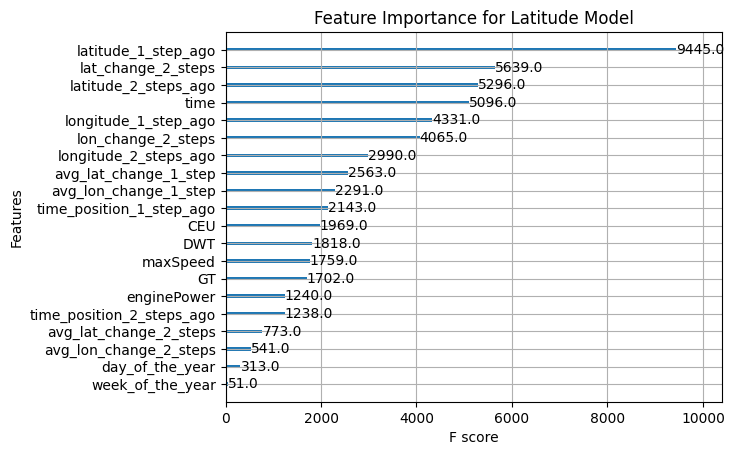

<Figure size 1000x600 with 0 Axes>

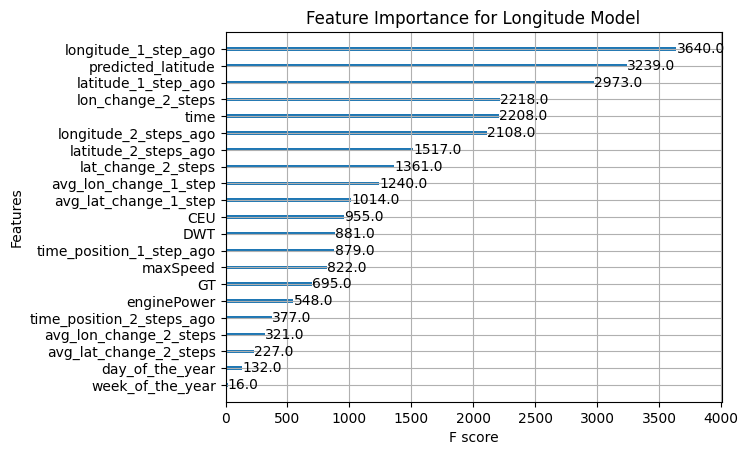

In [13]:
import matplotlib.pyplot as plt

# Plot feature importance for the Latitude model
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_latitude, importance_type='weight', title="Feature Importance for Latitude Model")
plt.show()

# Plot feature importance for the Longitude model
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_longitude, importance_type='weight', title="Feature Importance for Longitude Model")
plt.show()

In [14]:

expected_features = ['time', 'latitude_1_step_ago', 'longitude_1_step_ago', 'time_position_1_step_ago', 'latitude_2_steps_ago', 'longitude_2_steps_ago', 'time_position_2_steps_ago', 'week_of_the_year', 'day_of_the_year', 'lat_change_2_steps', 'lon_change_2_steps', 'avg_lat_change_1_step', 'avg_lat_change_2_steps', 'avg_lon_change_1_step', 'avg_lon_change_2_steps', 'enginePower', 'CEU', 'GT', 'DWT', 'maxSpeed']


# Load test data
test_X = pd.read_csv('data/processed_data/test_X.csv')
test_X["latitude_1_step_ago"] = np.nan
test_X["longitude_1_step_ago"] = np.nan
test_X["time_position_1_step_ago"] = np.nan
test_X["latitude_2_steps_ago"] = np.nan
test_X["longitude_2_steps_ago"] = np.nan
test_X["time_position_2_steps_ago"] = np.nan
test_X["lat_change_2_steps"] = np.nan
test_X["lon_change_2_steps"] = np.nan





# Sort training data and extract last known positions
train_X_with_vessel_ID = train_X_with_vessel_ID.sort_values(by=['vesselId', 'time'])

last_known_positions = train_X_with_vessel_ID.groupby('vesselId').agg({
    'latitude_1_step_ago': 'last',
    'longitude_1_step_ago': 'last',
    'time_position_1_step_ago': 'last',
    'latitude_2_steps_ago': 'last',
    'longitude_2_steps_ago': 'last',
    'time_position_2_steps_ago': 'last',
    'lat_change_2_steps': 'last',
    'lon_change_2_steps': 'last',
}).reset_index()

# Convert to dictionary for quick lookup
last_known_dict = last_known_positions.set_index('vesselId').to_dict('index')

# Initialize a list to store results
results_list = []

# Initialize tqdm progress bar
with tqdm(total=len(test_X), unit="row", desc="Making Predictions") as pbar:

    unique_vessel_ids = test_X["vesselId"].unique()

    for vessel_id in unique_vessel_ids:
        # Filter rows for the current vessel_id and reset index
        df = test_X[test_X["vesselId"] == vessel_id].reset_index(drop=True)

        for row in df.itertuples(index=True):
            idx = row.Index
            vessel_ID = row.vesselId
            row_ID = row.ID
            current_time = row.time

            # Retrieve last known position
            last_position = last_known_dict.get(vessel_ID, {
                'latitude_1_step_ago': np.nan,
                'longitude_1_step_ago': np.nan,
                'time_position_1_step_ago': np.nan,
                'latitude_2_steps_ago': np.nan,
                'longitude_2_steps_ago': np.nan,
                'time_position_2_steps_ago': np.nan,
                'lat_change_2_steps': np.nan,
                'lon_change_2_steps': np.nan,
            })

            lat_1_step_ago = last_position['latitude_1_step_ago']
            long_1_step_ago = last_position['longitude_1_step_ago']
            time_1_step_ago = last_position['time_position_1_step_ago']
            lat_2_steps_ago = last_position['latitude_2_steps_ago']
            long_2_steps_ago = last_position['longitude_2_steps_ago']
            time_2_steps_ago = last_position['time_position_2_steps_ago']
            lat_change_2_steps = last_position['lat_change_2_steps']
            lon_change_2_steps = last_position['lon_change_2_steps']

            if idx == 0:
                # Assign last known positions from training data
                test_X.at[row.Index, "latitude_1_step_ago"] = lat_1_step_ago
                test_X.at[row.Index, "longitude_1_step_ago"] = long_1_step_ago
                test_X.at[row.Index, "time_position_1_step_ago"] = time_1_step_ago
                test_X.at[row.Index, "latitude_2_steps_ago"] = lat_2_steps_ago
                test_X.at[row.Index, "longitude_2_steps_ago"] = long_2_steps_ago
                test_X.at[row.Index, "time_position_2_steps_ago"] = time_2_steps_ago
                test_X.at[row.Index, "lat_change_2_steps"] = lat_change_2_steps
                test_X.at[row.Index, "lon_change_2_steps"] = lon_change_2_steps
                

                # Prepare feature vector for prediction based on last known positions
                feature_vector = test_X.loc[row.Index, expected_features].to_frame().T
                feature_vector = feature_vector.apply(pd.to_numeric, errors='coerce')
                
                # Make predictions
                pred_lat = xgb_latitude.predict(feature_vector)[0]

                feature_vector['predicted_latitude'] = pred_lat
                pred_lon = xgb_longitude.predict(feature_vector)[0]

                # Append prediction to results list with current row's ID
                results_list.append({
                    "ID": row_ID,
                    "latitude_predicted": pred_lat,
                    "longitude_predicted": pred_lon,
                })

                # Update current row with predictions
                """ test_X.at[row.Index, "latitude_1_step_ago"] = pred_lat
                test_X.at[row.Index, "longitude_1_step_ago"] = pred_lon
                test_X.at[row.Index, "time_position_1_step_ago"] = current_time
                test_X.at[row.Index, "latitude_2_steps_ago"] = lat_1_step_ago
                test_X.at[row.Index, "longitude_2_steps_ago"] = long_1_step_ago
                test_X.at[row.Index, "time_position_2_steps_ago"] = time_1_step_ago
                test_X.at[row.Index, "lat_change_2_steps"] = pred_lat - lat_2_steps_ago
                test_X.at[row.Index, "lon_change_2_steps"] = pred_lon - long_2_steps_ago """


                # Update tracking dictionary with new predictions if not NaN
                if not pd.isna(pred_lat) and not pd.isna(pred_lon):
                    last_known_dict[vessel_ID] = {
                        'latitude_1_step_ago': pred_lat,
                        'longitude_1_step_ago': pred_lon,
                        'time_position_1_step_ago': current_time,
                        'latitude_2_steps_ago': lat_1_step_ago,
                        'longitude_2_steps_ago': long_1_step_ago,
                        'time_position_2_steps_ago': time_1_step_ago,
                        'lat_change_2_steps': pred_lat - lat_2_steps_ago,
                        'lon_change_2_steps': pred_lon - long_2_steps_ago,
                    }

                

            else:
                # Prepare feature vector for prediction based on previous row
                previous_row = test_X.iloc[row.Index - 1][expected_features].to_frame().T
                previous_row = previous_row.apply(pd.to_numeric, errors='coerce')

                # Make predictions
                pred_lat = xgb_latitude.predict(previous_row)[0]

                previous_row['predicted_latitude'] = pred_lat
                pred_lon = xgb_longitude.predict(previous_row)[0]

                # Append prediction to results list with current row's ID
                results_list.append({
                    "ID": row_ID,
                    "longitude_predicted": pred_lon,
                    "latitude_predicted": pred_lat
                })

                # Update current row with predictions
                test_X.at[row.Index, "longitude_1_step_ago"] = pred_lon
                test_X.at[row.Index, "latitude_1_step_ago"] = pred_lat
                test_X.at[row.Index, "time_position_1_step_ago"] = test_X.at[row.Index - 1, "time"]

                # Set the previous values for 2 steps ago from 1 step ago
                test_X.at[row.Index, "latitude_2_steps_ago"] = test_X.at[row.Index - 1, "latitude_1_step_ago"]
                test_X.at[row.Index, "longitude_2_steps_ago"] = test_X.at[row.Index - 1, "longitude_1_step_ago"]
                test_X.at[row.Index, "time_position_2_steps_ago"] = test_X.at[row.Index - 1, "time_position_1_step_ago"]

                # Calculate 2-step changes in latitude and longitude
                test_X.at[row.Index, "lat_change_2_steps"] = pred_lat - test_X.at[row.Index, "latitude_2_steps_ago"]
                test_X.at[row.Index, "lon_change_2_steps"] = pred_lon - test_X.at[row.Index, "longitude_2_steps_ago"]

                # Update the tracking dictionary `last_known_dict` with new predictions if not NaN
                if not pd.isna(pred_lat) and not pd.isna(pred_lon):
                    last_known_dict[vessel_ID] = {
                        'latitude_1_step_ago': pred_lat,
                        'longitude_1_step_ago': pred_lon,
                        'time_position_1_step_ago': test_X.at[row.Index - 1, "time"],
                        'latitude_2_steps_ago': test_X.at[row.Index, "latitude_2_steps_ago"],
                        'longitude_2_steps_ago': test_X.at[row.Index, "longitude_2_steps_ago"],
                        'time_position_2_steps_ago': test_X.at[row.Index, "time_position_2_steps_ago"],
                        'lat_change_2_steps': test_X.at[row.Index, "lat_change_2_steps"],
                        'lon_change_2_steps': test_X.at[row.Index, "lon_change_2_steps"]
                    }

            # Update the progress bar
            pbar.update(1)
            print(f"Row: {test_X.iloc[row.Index]}")
            print(f"Pred lat: {pred_lat}, Pred long: {pred_lon}")

# Convert the results list to a DataFrame and sort by ID
results = pd.DataFrame(results_list).sort_values(by=['ID'])

# Save predictions to CSV
results.to_csv("data/v4.csv", index=False)


Making Predictions:   0%|          | 62/51739 [00:00<02:49, 305.58row/s]

Row: ID                                                  4
vesselId                     61e9f38eb937134a3c4bfd8d
time                                          0.34975
week_of_the_year                             0.346154
day_of_the_year                              0.350685
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                          48.53133
longitude_1_step_ago                          -6.1075
time_position_1_step_ago                     0.349648
latitude_2_steps_ago                         48.53133
longitude_2_steps_ago  

Making Predictions:   0%|          | 125/51739 [00:00<02:48, 306.25row/s]

Row: ID                                              16515
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.354353
week_of_the_year                             0.346154
day_of_the_year                              0.353425
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         48.777264
longitude_1_step_ago                        -5.940892
time_position_1_step_ago                     0.354313
latitude_2_steps_ago                        48.833099
longitude_2_steps_ago  

Making Predictions:   0%|          | 156/51739 [00:00<03:44, 229.62row/s]

Row: ID                                              27563
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.357159
week_of_the_year                             0.346154
day_of_the_year                              0.356164
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         48.806313
longitude_1_step_ago                        -6.034323
time_position_1_step_ago                     0.357121
latitude_2_steps_ago                        48.770832
longitude_2_steps_ago  

Making Predictions:   0%|          | 216/51739 [00:00<03:13, 266.25row/s]

Row: ID                                              32986
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.358521
week_of_the_year                             0.346154
day_of_the_year                              0.358904
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         48.770832
longitude_1_step_ago                         -6.00479
time_position_1_step_ago                     0.358489
latitude_2_steps_ago                        48.767605
longitude_2_steps_ago  

Making Predictions:   0%|          | 245/51739 [00:00<03:23, 252.78row/s]

Row: ID                                              48494
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.362553
week_of_the_year                             0.346154
day_of_the_year                              0.361644
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         48.779831
longitude_1_step_ago                        -6.034239
time_position_1_step_ago                     0.362496
latitude_2_steps_ago                        48.756725
longitude_2_steps_ago  

Making Predictions:   1%|          | 305/51739 [00:01<03:29, 245.88row/s]

Row: ID                                               1891
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.350257
week_of_the_year                             0.346154
day_of_the_year                              0.350685
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         51.481991
longitude_1_step_ago                        -2.900832
time_position_1_step_ago                     0.350211
latitude_2_steps_ago                         51.48122
longitude_2_steps_ago  

Making Predictions:   1%|          | 364/51739 [00:01<03:11, 268.08row/s]

Row: ID                                              19527
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.355152
week_of_the_year                             0.346154
day_of_the_year                              0.353425
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         51.482513
longitude_1_step_ago                         -2.95873
time_position_1_step_ago                     0.355113
latitude_2_steps_ago                        51.478973
longitude_2_steps_ago  

Making Predictions:   1%|          | 392/51739 [00:01<03:58, 215.14row/s]

Row: ID                                              28417
vesselId                     61e9f38eb937134a3c4bfd8d
time                                          0.35738
week_of_the_year                             0.346154
day_of_the_year                              0.356164
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         51.478973
longitude_1_step_ago                        -2.921041
time_position_1_step_ago                     0.357344
latitude_2_steps_ago                        51.478989
longitude_2_steps_ago  

Making Predictions:   1%|          | 448/51739 [00:01<03:32, 241.75row/s]

Row: ID                                              39632
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.360217
week_of_the_year                             0.346154
day_of_the_year                              0.358904
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         51.482513
longitude_1_step_ago                         -2.98818
time_position_1_step_ago                     0.360111
latitude_2_steps_ago                        51.482597
longitude_2_steps_ago  

Making Predictions:   1%|          | 507/51739 [00:02<03:12, 266.44row/s]

Row: ID                                              48853
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.362655
week_of_the_year                             0.346154
day_of_the_year                              0.361644
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                         51.478973
longitude_1_step_ago                        -2.921041
time_position_1_step_ago                      0.36261
latitude_2_steps_ago                        51.478989
longitude_2_steps_ago  

Making Predictions:   1%|          | 535/51739 [00:02<03:47, 224.78row/s]

Row: ID                                               3800
vesselId                     61e9f399b937134a3c4bfdb7
time                                         0.350783
week_of_the_year                             0.346154
day_of_the_year                              0.350685
avg_lat_change_1_step                        0.021291
avg_lat_change_2_steps                       0.042586
avg_lon_change_1_step                       -0.102086
avg_lon_change_2_steps                      -0.204427
enginePower                                  0.333333
CEU                                          0.890941
GT                                           0.738011
DWT                                          0.159464
maxSpeed                                     0.757576
latitude_1_step_ago                         51.484222
longitude_1_step_ago                        -2.941794
time_position_1_step_ago                     0.350744
latitude_2_steps_ago                        51.484238
longitude_2_steps_ago  

Making Predictions:   1%|          | 602/51739 [00:02<03:08, 271.35row/s]

Row: ID                                              11197
vesselId                     61e9f399b937134a3c4bfdb7
time                                         0.352872
week_of_the_year                             0.346154
day_of_the_year                              0.353425
avg_lat_change_1_step                        0.021291
avg_lat_change_2_steps                       0.042586
avg_lon_change_1_step                       -0.102086
avg_lon_change_2_steps                      -0.204427
enginePower                                  0.333333
CEU                                          0.890941
GT                                           0.738011
DWT                                          0.159464
maxSpeed                                     0.757576
latitude_1_step_ago                         51.484222
longitude_1_step_ago                        -2.941794
time_position_1_step_ago                     0.352833
latitude_2_steps_ago                        51.484238
longitude_2_steps_ago  

Making Predictions:   1%|▏         | 667/51739 [00:02<02:55, 291.72row/s]

Row: ID                                              10960
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.352829
week_of_the_year                             0.346154
day_of_the_year                              0.353425
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                        -22.284649
longitude_1_step_ago                        54.063534
time_position_1_step_ago                     0.352794
latitude_2_steps_ago                        -4.928738
longitude_2_steps_ago  

Making Predictions:   1%|▏         | 731/51739 [00:02<03:13, 263.65row/s]

Row: ID                                              19688
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.355191
week_of_the_year                             0.346154
day_of_the_year                              0.353425
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                        -24.700838
longitude_1_step_ago                        49.033165
time_position_1_step_ago                     0.355152
latitude_2_steps_ago                       -24.700838
longitude_2_steps_ago  

Making Predictions:   2%|▏         | 797/51739 [00:03<02:53, 293.59row/s]

Row: ID                                              28760
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.357461
week_of_the_year                             0.346154
day_of_the_year                              0.356164
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                        -24.700838
longitude_1_step_ago                        49.033165
time_position_1_step_ago                     0.357422
latitude_2_steps_ago                       -24.700838
longitude_2_steps_ago  

Making Predictions:   2%|▏         | 808/51739 [00:03<03:21, 252.93row/s]


Row: ID                                              45676
vesselId                     61e9f38eb937134a3c4bfd8d
time                                         0.361821
week_of_the_year                             0.346154
day_of_the_year                              0.361644
avg_lat_change_1_step                       -0.000462
avg_lat_change_2_steps                      -0.000924
avg_lon_change_1_step                       -0.001555
avg_lon_change_2_steps                      -0.003109
enginePower                                  0.368696
CEU                                          0.576706
GT                                           0.415611
DWT                                          0.086343
maxSpeed                                     0.837412
latitude_1_step_ago                        -24.700838
longitude_1_step_ago                        49.033165
time_position_1_step_ago                     0.361785
latitude_2_steps_ago                       -24.700838
longitude_2_steps_ago  

KeyboardInterrupt: 